# Language Modeling & Text Generation from IMDB
We will be looking at IMDB movie reviews. We want to determine if a review is negative or positive, based on the text. In order to do this, we will be using **Transfer Learning**

Transfer learning has been widely used with great success in computer vision for several years, but only in the last yar or so has it been successfully applied to NLP.

# Using a GPU
In this notebook we will be using a RTX 2070-MaxQ GPU

In [1]:
from fastai import *
from fastai.text import *
import torch

In [2]:
# Printing our device name - you will need a GPU
print(torch.cuda.device_count()) # how many GPUs?

device_ = torch.cuda.current_device() # get current device
torch.cuda.get_device_name(device_) # printing the device name

1


'GeForce RTX 2070 with Max-Q Design'

In [3]:
# Let's set the device
torch.cuda.set_device(device_)

In [4]:
# Setting our batch-size, depending on the memory we may need to decrease this
bs = 48

## Preparing the data (on a sample)
We will first download the dataset we will use which contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing. The remaining 50,000 is an additional unlabelled data.

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)

In [8]:
# Checking the path of our data
path.ls()

[WindowsPath('C:/Users/dmber/.fastai/data/imdb_sample/texts.csv')]

As you see, this only contains one csv file. It contains one line per review, with the label (negative, positive), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [10]:
# using DataBunch API
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two different steps: **Tokenization** and **Numericalization**. ```TextDataBunch``` does this all for us behind the scenes.

## Tokenization
The first step of processing we make texts go through is to split the raw sentences into words, or more exactly **tokens**. The easiest way to do this would be to split the string into space, but ```TextDataBunch``` does more:
* We need to take care of punctuation
* Some words are contractions of two different words, like isn't or don't
* We may need to clean some parts of our texts, if there's HTML code for instance

The texts are truncated at 100 tokens for more readability. We can see that it did more than jsut split on space and punctuation symbols:
* The "s" are grouped together in one token
* The contraction are seperated like this: "did", "n't"
* The content has been cleaned for any HMTL symbol and lower cased
* There are several special tokens

## Numericalization
Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token ```UNK```.

The correspondance from ids tokens is stored in the ```vocab``` attribute of our datasets, in a dictionary called ```itos``` (int to string). This is actually a list.

In [13]:
# Grabbing the first 20 tokens in our vocab
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

In [14]:
# checking the length of our vocab
len(data_lm.vocab.itos)

8880

In [15]:
# Let's check one example from our train dataset
data_lm.train_ds[0][0]

Text xxbos xxmaj this was the first xxmaj ewan mcgregor movie i ever saw outside of xxmaj star xxmaj wars . xxmaj since then i have become a very big xxmaj ewan mcgregor fan but i still ca n't bring myself to forgive this movie 's existence . 
 
  xxmaj my sister has always been a huge xxmaj jane xxmaj austen fan and because of that , i have been subjected to various of the classics , xxmaj emma being one of them . i 've always considered them irritating , stupid and boring . xxmaj however , after watching this terrible rendition , i was forced to admit that the original xxmaj emma was delightful and charming . xxmaj ewan mcgregor scarcely serves a purpose in this film after they hacked and xxunk the part of xxmaj frank xxmaj xxunk . xxmaj xxunk xxmaj paltrow is ridiculous in an already ridiculous character and the rest of the film is xxunk and stupid . 
 
  xxmaj my recommendation to anybody who is remotely interested in xxmaj english period drama ... go see the originals . xxmaj if y

## Alternative, Flexible Approach
We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous examples for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the datablock API though, we have to manually call the tokenize and numerical steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable

In [16]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [17]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [18]:
len(data.vocab.itos)

6016

As you see there are less vocab because we didn't feed any manual parameters into ```.databunch``` which you can. Just look at the FASTAI documentation to learn more.

# Full Dataset - Language Model
Now we will do the same but with the larger full dataset

In [6]:
# This may take a while ~ 5 min
path = untar_data(URLs.IMDB)

In [9]:
path.ls()

[WindowsPath('C:/Users/dmber/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/unsup')]

In [10]:
# Checking our train directory
(path/"train").ls()

[WindowsPath('C:/Users/dmber/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/train/unsupBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an ```unsup``` folder that contains unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model **pretrained** on a bigger dataset (wikitext-103). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point. 

We're going to use that "knowledge" of the english language to build or classifier, but first, like for computer vision, we need to fine-tune the pre-trained model to our particular dataset. Because the english of the reviews left by people on IMDB isn't the same as the english of wikipedia, we'll need to adjust a little bit of the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefor might not be part of the vocabulary the model was trained on.

## Creating the ```TextLMDataBunch```
This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the datablock API.

As you will notice, we are not trying to predict **sentiment** in the following cells, but are actually predicting the **next word** to build a fine-tuned language model.

In [11]:
data_lm = (TextList.from_folder(path)
                    # Using all text files in our path : train and test
                   .filter_by_folder(include=['train', 'test'])
                    # We will keep 10% for validation
                   .random_split_by_pct(0.1)
                    # Telling DB API we are labeling for a language model
                   .label_for_lm()
                    # specifying our batchsize
                   .databunch(bs=bs))

In [12]:
# Checking the size of our new vocab
len(data_lm.vocab.itos)

49848

In [13]:
# Just like a df we can show part of our file
data_lm.show_batch(3)

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,", idea for the movie . \n \n xxmaj overall , this flick deserves 4 / 10 from me . xxmaj it 's not as bad as people say . xxmaj imagine a xxup zombie xxup western , then watch this movie . xxbos xxmaj produced by xxmaj nott xxmaj entertainment , this movie is "" nott "" very good at all . i sat through the first 15"
2,"xxmaj the rest of the aggressive bunch are xxmaj askew ( one of the only three survivors ) , xxmaj xxunk , xxmaj lucking , xxmaj lauter ; xxmaj rita xxmaj rogers is truly hot , fleshy beauty . xxbos xxmaj the director was probably still in his early learning stages when he tried his hand at westerns . xxmaj have a look at the outfits . xxmaj everybody looks"


In [14]:
# We can save our databunch so we can pickup where we left off
data_lm.save('lm_databunch')

In [7]:
# # How to load the databunch
data_lm = load_data(path, 'lm_databunch', bs=bs)

In [9]:
data_lm.train_ds[0]

(Text xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic here , it was all i could do t

## Language Model - pretrained

In [10]:
# Creating our language model - Pretrained
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).to_fp16()

In [31]:
# want to know more about this pre-trained model?
# https://arxiv.org/pdf/1708.02182.pdf
? AWD_LSTM

Init signature:
 AWD_LSTM(
    vocab_sz: int,
    emb_sz: int,
    n_hid: int,
    n_layers: int,
    pad_token: int = 1,
    hidden_p: float = 0.2,
    input_p: float = 0.6,
    embed_p: float = 0.1,
    weight_p: float = 0.5,
    qrnn: bool = False,
    bidir: bool = False,
)
Docstring:      AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182.
File:           c:\users\dmber\anaconda3\lib\site-packages\fastai\text\models\awd_lstm.py
Type:           PrePostInitMeta
Subclasses:     


### More on ```AWD_LSTM``` 
AWD_LSTM(vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1,hidden_p:float=0.2, input_p:float=0.6,embed_p:float=0.1,weight_p:float=0.5, qrnn:bool=False, bidir:bool=False)

*directly from FASTAI documentation*
The main idea from the white-paper implementation of this model is to use an **RNN** with dropout everywhere, but in an intelligent way. 

There is a difference with the usual dropout, which is why we will see ```RNNDropout``` module: we zero things, as in usual dropout, but we always zero the same thing accordingly to the sequence dimension (when is the first dimension in PyTorch). This ensures consistency when updating the hidden state through the whole sentence/articles.

There are a total of four different dropouts in the encoder of the AWD-LSTM:
* the first one, embedding dropout, is applied when we look the ids of our tokens inside the embedding matrix (to transform them from numbers to a vector of float). We zero some lines of it, so random ids are sent to a vector of zeros instead of being sent to their embedding vector. This is the ```embed_p``` parameter
* the second one, input dropout, is applied to the result of the embedding with dropout. We forget random pieces of the embedding matrix (but as stated in the last paragraph, the same ones in the sequence dimension). This is the ```input_p``` parameter.
* the third one, is the weight dropout. It's the trickiest to implement as we randomly replace by 0s some weights of the hidden-to-hidden matrix inside the RNN: this needs to be done is a way that ensures the gradients are still computed and the initial weights still updated. This is the ```weight_p``` parameter.
* the fourth one, is the hidden dropout. It's applied to the output of one of the layers of the RNN before it's used as input of the next layer (again same coordinates are zeroed in the sequence dimension). It isn't applied to the last output (which will get its own dropout in the decoder). This is the ```hidden_p``` parameter.

The other attributes are:
* ```vocab_sz```: number of tokens in your vocabulary
* ```emb_sz```: the embedding size
* ```n_hid```: for the hidden size of your inner LSTMs (or QRNNs)
* ```n_layers```: the number of layers - how many LSTM cells
* ```pad_token```: for the index of an eventual padding token (1 by default)

If you use: ```qrnn=True``` you will replace inner LSTMs by QRNNs. 

**QRNNs** are: Quasi-Recurrent Neural Networks. To learn more visit: https://arxiv.org/abs/1611.01576

In [37]:
# You can actually override the AWS_LSTM model by calling a new model and calling super on it

In [36]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(49848, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(49848, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=49848, bias=True)
    (output_dp): RNNDropout()
  )
)

In [30]:
# To view all the models just run: 
# text.models

Type:        module
String form: <module 'fastai.text.models' from 'C:\\Users\\dmber\\Anaconda3\\lib\\site-packages\\fastai\\text\\models\\__init__.py'>
File:        c:\users\dmber\anaconda3\lib\site-packages\fastai\text\models\__init__.py
Source:     
from .awd_lstm import *
from .transformer import *
__all__ = [*awd_lstm.__all__, *transformer.__all__]


### More on Wikitext-103

In [42]:
# Pulling our wiki vocab
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

In [43]:
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [44]:
# length of the wiki text vocab
len(wiki_itos)

60000

In [45]:
# Grabbing our vocab
vocab = data_lm.vocab

In [46]:
len(vocab.itos)

49848

### Generating Fake Movie Reviews (Using Wiki-Text Model)

In [49]:
# We call learn_lm.predict() - to generate our text
? learn_lm.predict

Signature:
 learn_lm.predict(
    text: str,
    n_words: int = 1,
    no_unk: bool = True,
    temperature: float = 1.0,
    min_p: float = None,
    sep: str = ' ',
    decoder=<function decode_spec_tokens at 0x000001DC2581D7B8>,
)
Docstring: Return the `n_words` that come after `text`.
File:      c:\users\dmber\anaconda3\lib\site-packages\fastai\text\learner.py
Type:      method


In [11]:
def generate_fake_review(language_model_, text_, n_words_=40, n_sentences_=2, temp_=0.75):
    """
    ARGS:
        language_model_: <language model object>
        text_: <str>: Beginning text, generation will occur from this
        n_words_: <int>: Number of words to generate
        n_sententences_: <int>: Number of sentences to generate
        temp_: <float>: How much randomness?
        
    RETURN:
        Will return generated text from language model
    """
    return "\n".join(language_model_.predict(text_, n_words_, temperature=temp_) for _ in range(n_sentences_))

In [12]:
text = "Smoking a juul before going to bed is good because"
generated_text = generate_fake_review(learn_lm, text, n_words_=50, n_sentences_=1, temp_=0.99)
print(generated_text)

Smoking a juul before going to bed is good because of the lack of appetite for the gatherings . On playhouse , a young man who raced was called the Son of Halloween . interesting people , such as over - age men who want to eat eating merchandise interspersed with spending locations , occur frequently ,


# Training The Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


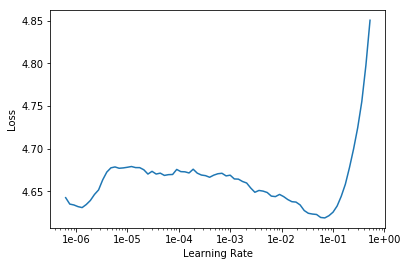

In [72]:
# Finding the optimal learning rate
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=15)

In [73]:
lr = 1e-2
learn_lm.fit_one_cycle(1, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.152680,4.953022,0.314286,08:25


In [74]:
# Saving the model
learn_lm.save('fit_1')

In [13]:
# # Loading the model if we need to 
learn_lm.load('fit_1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no 

In [16]:
# If you're wondering where the model exist, it exist within this path under /models
path.ls()

[WindowsPath('C:/Users/dmber/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/lm_databunch'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/dmber/.fastai/data/imdb/unsup')]

In [18]:
# To Fine-Tune we will unfreeze all the weights to adjust all parameters
torch.cuda.empty_cache()

In [19]:
# Finding optimal learning rate once more
learn_lm.unfreeze()

In [20]:
learn_lm.fit_one_cycle(4, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.879189,3.852729,0.313177,09:50
1,3.774131,3.775172,0.323474,09:46
2,3.629352,3.716798,0.330592,09:42
3,3.500514,3.710171,0.331989,09:51


In [21]:
# Saving the new trained model
learn_lm.save('fine_tuned1')

In [ ]:
# # If you would like to load in the pre-trained model that's not fine-tuned run the following cell
# learn_lm.load('fine_tuned1')

In [22]:
# grabbing out encoder
# remember that an LSTM-RNN is composed of an encoder network and decoder network
encoder = learn_lm.model[0].encoder

In [23]:
# Testing our new model now to generate text
TEXT = 'i liked this movie because'
fr = generate_fake_review(learn_lm, TEXT)
print(fr)

i liked this movie because it was kind of a very good movie . It was about a family that is still living in the United States after the war . The family is very well concerned and they do n't
i liked this movie because i loved it . But the plot did n't really make an impact . They could have used a joke as a camera . But i did . The story was good , and the story


In [24]:
TEXT = 'this movie was'
fr = generate_fake_review(learn_lm, TEXT, n_sentences_=1)
print(fr)

this movie was the worst movie i 've ever seen . i laughed so hard i got to laugh my head off . the acting is terrible . and the characters are all stupid . and the movie is boring . i mean


In [25]:
# Training for one more time
learn_lm.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.566832,3.715657,0.331932,10:33
